In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.io import wavfile
import scipy
import stft
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from time import perf_counter
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense, Activation

/Users/georgeoblapenko/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/georgeoblapenko/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
%matplotlib inline

First, let's load some audio

In [3]:
train_audio_name = 'schonberg'  # what audio we will train on
gen_audio_name = 'schonberg'  # what audio will be used as a seed for generation
original_audio_list = {'reich': '01-18_Pulses.wav', 'branca': '04-LightField.wav',
                       'schonberg': '2-05_Phantasy_for_Violin_and_Piano.wav',
                       'bach': '08_Contrapunctus_VIIIa_3.wav',
                       'handel': '1-03_Water_Music_Suite_No_1_inFMajHWV_348_III_AllegroAndanteAllegro.wav'}

In [4]:
rate, data = wavfile.read(original_audio_list[train_audio_name])

Next, we'll compute a spectrogram of a mono signal (obtained by summing the L & R channels) and using the default (cosine) window function

In [5]:
overlap = 4
framelength = 1024

specgram = stft.spectrogram((data[:, 1] + data[:, 0]), framelength=framelength, overlap=overlap)

We're interested in the absolute values of the spectrogram, and we'll log-scale it

In [6]:
log_spectrogram = np.log(1 + scipy.absolute(specgram))  # X axis - frequency bins, Y axis - time
print(log_spectrogram.shape)

(513, 56249)


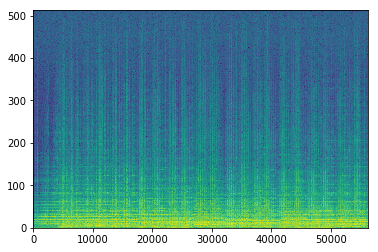

In [7]:
plt.imshow(log_spectrogram, origin='lower', aspect='auto',
           interpolation='nearest')

Now we'll specify for each moment of time `t` which preceding intervals of the form `[t-a,t-b]` we want to use for feature extraction. So if for each interval we have `N` different features, the total amount of different features we'll have is equal to `N * n_intervals`.

We want to have varied information from the audio, so we sample features not for every frame, but each `step_size` frames.

In [8]:
# steps = [(-3000, 0), (-2000, 0), (-1000, 0), (-500, 0), (-250, 0), (-100, 0), (-50, 0), (-25, 0), (-10, 0), (-6, 0)]
steps = [(-3000, 0), (-2000, 0), (-1000, 0), (-500, 0), (-250, 0), (-100, 0), (-50, 0), (-25, 0), (-10, 0)]

min_offset = max([-(i[0]) for i in steps])
step_size = 2

In [9]:
min_offset

3000

We want to have the frequency content of an interval as a (vector) feature; but we have too many frequency bins, so we just reduce their number by summation of their content.

In [10]:
freq_avg_step = 9
num_freq_bins_reduced = log_spectrogram.shape[0]//freq_avg_step

freq_avg_step_large = 57
num_freq_bins_reduced_large = log_spectrogram.shape[0]//freq_avg_step_large
print(num_freq_bins_reduced, num_freq_bins_reduced_large)

57 9


Some feature extraction functions

In [11]:
def get_max_amplitude(spgram_slice):
    return np.max(spgram_slice)

In [12]:
def get_min_amplitude(spgram_slice):
    return np.min(spgram_slice)

In [13]:
def get_amplitude_change2(spgram_slice):
    a = np.sum(spgram_slice[:, :spgram_slice.shape[1]//2]) - np.sum(spgram_slice[:, spgram_slice.shape[1]//2:])
    return a / spgram_slice.shape[1]

In [14]:
def get_avg_amplitude(spgram_slice):
    return np.sum(spgram_slice) / spgram_slice.shape[1]  # get average "volume"

In [15]:
def get_max_vol(spgram_slice):
    return np.max(np.sum(spgram_slice,axis=0))

In [16]:
def get_min_vol(spgram_slice):
    return np.min(np.sum(spgram_slice,axis=0))

In [17]:
def get_median_amplitude(spgram_slice):
    return np.median(spgram_slice)

In [18]:
def get_loudest_bins(spgram_slice):
    tmp = np.sum(spgram_slice, axis=1)
    return np.argpartition(tmp, -N_loudest_bins_to_get)[-N_loudest_bins_to_get:]

Now we let's extract the features and the spectral content for each frame;
or we can load a pre-computed feature file and use only the features we want

In [19]:
feature_list = [get_max_amplitude, get_min_amplitude,
                get_avg_amplitude, get_amplitude_change2, get_median_amplitude]
N_loudest_bins_to_get = 10
N_prev_frames = 10

get_slice_freq_bins = True
# get_slice_freq_bins = False  # if true, we take mean of enlarged frequency bin over a slice

freq_bin_feature_list = [get_max_amplitude, get_min_amplitude,
                         get_avg_amplitude, get_median_amplitude]

In [20]:
nfeat = len(feature_list) * len(steps) + num_freq_bins_reduced * N_prev_frames + N_loudest_bins_to_get * len(steps)
if get_slice_freq_bins:
    nfeat += len(steps) * num_freq_bins_reduced
nfeat += len(freq_bin_feature_list) * len(steps) * num_freq_bins_reduced_large
# number of features - we have several scalar features for each slice of audio

print(nfeat)

1542


In [21]:
fbr_Npf = num_freq_bins_reduced * N_prev_frames

In [22]:
def get_features_for_frame(log_spgram_slice, scalar_functions, n_features):
    res = np.zeros(n_features)
    counter = 0
    for slicing in steps:
        for s_f in scalar_functions:
            res[counter] = s_f(log_spgram_slice[:, min_offset + slicing[0]:min_offset + slicing[1]])
            counter += 1
        if N_loudest_bins_to_get > 0:
            res[counter:counter+N_loudest_bins_to_get] = get_loudest_bins(log_spgram_slice[:, min_offset + slicing[0]:min_offset + slicing[1]])
            counter += N_loudest_bins_to_get
            
    # we reverse and transpose so that when we load from a file and want to use a smaller number of previous frames,
    # we load the correct bins/slices
    res[counter:counter+fbr_Npf] = log_spgram_slice[::freq_avg_step, -1-N_prev_frames:-1].transpose().flatten()[::-1]
    counter += num_freq_bins_reduced * N_prev_frames
    if get_slice_freq_bins:
        for slicing in steps:
            res[counter:counter+num_freq_bins_reduced] = np.mean(log_spgram_slice[::freq_avg_step, min_offset + slicing[0]:min_offset + slicing[1]],axis=1).flatten()
            counter += num_freq_bins_reduced
    for slicing in steps:
        for s_f in freq_bin_feature_list:
            for i in range(num_freq_bins_reduced_large):
                res[counter] = s_f(log_spgram_slice[freq_avg_step*i:freq_avg_step_large*(i+1),
                                                    min_offset + slicing[0]:min_offset + slicing[1]])
                counter += 1
    return res

In [23]:
def get_feature_names():
    res = []
    for slicing in steps:
        for s_f in feature_list:
            name = s_f.__name__[4:] + '_'
            name += str(slicing[0]) + '_' + str(slicing[1])
            res.append(name)
        for bin_no in range(N_loudest_bins_to_get):
            res.append('loudest_bin_' + str(bin_no))
    for i in range(fbr_Npf):
        res.append('prev_frames_flattened_' + str(i))
    if get_slice_freq_bins:
        for slicing in steps:
            for i in range(num_freq_bins_reduced):
                name = 'freq_binr_' + str(i) + '_mean_'
                name += str(slicing[0]) + '_' + str(slicing[1])
                res.append(name)
    for slicing in steps:
        for s_f in freq_bin_feature_list:
            for i in range(num_freq_bins_reduced_large):
                name = 'freq_binr_' + str(i) + '_' + s_f.__name__[4:] + '_'
                name += str(slicing[0]) + '_' + str(slicing[1])
                res.append(name)
    return res

In [24]:
def process_spectrogram(log_spgram, scalar_functions, n_slices, n_features):
    # features, frequency content - X, Y
    # n_slices - the number of data points
    loc_Y = np.zeros([n_slices, log_spgram.shape[0]])
    loc_X = np.zeros([n_slices, n_features])
    for i in range(n_slices):
        if i%200 == 0:
            print(i)
        loc_Y[i] = log_spgram[:, min_offset + step_size * i]
        loc_X[i, 0:n_features] = get_features_for_frame(log_spgram[:,step_size * i:min_offset
                                                                     + step_size * i], scalar_functions, n_features)
    return [loc_X, loc_Y]

In [25]:
load_from_file = True
features_filename = 'data/branca20k_step22017_10_11_10_features.csv'
target_filename = 'data/branca20k_step2_target.csv'

n_samples = 1000

if not load_from_file:
    start_time = perf_counter()
    X, Y = process_spectrogram(log_spectrogram, feature_list,
                               n_samples, nfeat)
    print(perf_counter() - start_time)
else:
    df_features = pd.read_csv(features_filename)
    df_target = pd.read_csv(target_filename)
    df_features = df_features.drop('timestep', axis=1)
    df_target = df_target.drop('timestep', axis=1)
    
    step_df = df_features.shape[0] // n_samples
    df_features = df_features[::step_df]
    df_target = df_target[::step_df]
    
    feature_cols = get_feature_names()
    df_features = df_features[feature_cols]
    
    X = df_features.values
    Y = df_target.values

If we didn't read the features and target data from a file, we'll write them to disk

In [26]:
if not load_from_file:
    audio_name = train_audio_name + str(n_samples//1000) + 'k_step' + str(step_size) 

    index_array = [min_offset + i * step_size for i in range(n_samples)]

    df = pd.DataFrame({'timestep' : index_array})

    feature_names = get_feature_names()
    for i, f_n in enumerate(feature_names):
        df[f_n] = X[:, i]

    curr_time = datetime.now()
    curr_t_str = str(curr_time.year) + '_' + str(curr_time.month) + '_' + str(curr_time.day) + '_' + str(curr_time.hour)

    df.to_csv('data/' + audio_name + curr_t_str + '_features.csv', index=False)
    
    df = pd.DataFrame({'timestep' : index_array})

    for i in range(log_spectrogram.shape[0]):
        df['freqbin_' + str(i)] = Y[:, i]

    df.to_csv('data/' + audio_name + '_target.csv', index=False)

In [27]:
%reset_selective -f df_features
%reset_selective -f df_target

Next, we scale the features and the target values

In [28]:
feature_scaler_freq = StandardScaler()
X = feature_scaler_freq.fit_transform(X)

freq_Y_mean = np.mean(Y)
freq_Y_std = np.std(Y)

Y = (Y - freq_Y_mean) / freq_Y_std

Then, we train a neural network

In [39]:
model = Sequential()
model.add(Dense(500, activation='tanh', input_dim=X.shape[1]))
model.add(Dense(500, activation='tanh'))
model.add(Dense(500, activation='sigmoid'))
model.add(Dense(Y.shape[1], activation='relu'))
model.compile(optimizer='rmsprop',
              loss='mean_squared_error',
              metrics=['accuracy'])
predictor = model

In [40]:
start_time = perf_counter()


predictor.fit(X, Y, epochs=300, batch_size=64, verbose=2)

print(perf_counter() - start_time)

Epoch 1/300
 - 1s - loss: 0.6862 - acc: 0.2440
Epoch 2/300
 - 0s - loss: 0.6332 - acc: 0.2990
Epoch 3/300
 - 0s - loss: 0.6273 - acc: 0.2870
Epoch 4/300
 - 0s - loss: 0.6189 - acc: 0.2980
Epoch 5/300
 - 0s - loss: 0.6158 - acc: 0.3200
Epoch 6/300
 - 0s - loss: 0.6103 - acc: 0.3300
Epoch 7/300
 - 0s - loss: 0.6072 - acc: 0.3180
Epoch 8/300
 - 0s - loss: 0.6066 - acc: 0.3400
Epoch 9/300
 - 0s - loss: 0.6031 - acc: 0.3500
Epoch 10/300
 - 0s - loss: 0.5997 - acc: 0.3370
Epoch 11/300
 - 0s - loss: 0.5998 - acc: 0.3520
Epoch 12/300
 - 0s - loss: 0.5976 - acc: 0.3520
Epoch 13/300
 - 0s - loss: 0.5944 - acc: 0.3560
Epoch 14/300
 - 0s - loss: 0.5917 - acc: 0.3740
Epoch 15/300
 - 0s - loss: 0.5852 - acc: 0.3700
Epoch 16/300
 - 0s - loss: 0.5832 - acc: 0.3460
Epoch 17/300
 - 0s - loss: 0.5840 - acc: 0.3580
Epoch 18/300
 - 0s - loss: 0.5806 - acc: 0.3560
Epoch 19/300
 - 0s - loss: 0.5753 - acc: 0.3900
Epoch 20/300
 - 0s - loss: 0.5665 - acc: 0.3770
Epoch 21/300
 - 0s - loss: 0.5582 - acc: 0.3970
E

Epoch 171/300
 - 0s - loss: 0.4829 - acc: 0.7290
Epoch 172/300
 - 0s - loss: 0.4828 - acc: 0.7190
Epoch 173/300
 - 0s - loss: 0.4831 - acc: 0.7190
Epoch 174/300
 - 0s - loss: 0.4828 - acc: 0.7210
Epoch 175/300
 - 0s - loss: 0.4827 - acc: 0.7300
Epoch 176/300
 - 0s - loss: 0.4828 - acc: 0.7140
Epoch 177/300
 - 0s - loss: 0.4828 - acc: 0.7310
Epoch 178/300
 - 0s - loss: 0.4828 - acc: 0.7320
Epoch 179/300
 - 0s - loss: 0.4827 - acc: 0.7370
Epoch 180/300
 - 0s - loss: 0.4828 - acc: 0.7270
Epoch 181/300
 - 0s - loss: 0.4827 - acc: 0.7370
Epoch 182/300
 - 0s - loss: 0.4826 - acc: 0.7230
Epoch 183/300
 - 0s - loss: 0.4826 - acc: 0.7240
Epoch 184/300
 - 0s - loss: 0.4826 - acc: 0.7230
Epoch 185/300
 - 0s - loss: 0.4827 - acc: 0.7350
Epoch 186/300
 - 0s - loss: 0.4826 - acc: 0.6950
Epoch 187/300
 - 0s - loss: 0.4826 - acc: 0.7080
Epoch 188/300
 - 0s - loss: 0.4825 - acc: 0.7150
Epoch 189/300
 - 0s - loss: 0.4828 - acc: 0.7170
Epoch 190/300
 - 0s - loss: 0.4826 - acc: 0.7430
Epoch 191/300
 - 0s 

Let's then try and generate some new audio (frequency amplitude; we'll fill the phase data with uniformly distributed noise) and compare it with the real audio, to assess the performance of our model. First, we'll take a chunk of the audio that hasn't been fed to our model before, to use a starting point.
At some point, the model will only generate audio based on only newly generated audio.
We can also load a different waveform to generate audio based on a model trained on different audio

In [41]:
# rate, data = wavfile.read('results/reich_dt_d10_10k_nominmax.wav')
# overlap = 4
# framelength = 1024

# specgram = stft.spectrogram((data[:, 1] + data[:, 0]), framelength=framelength, overlap=overlap)
# log_spectrogram = np.log(1 + scipy.absolute(specgram))  # X axis - frequency bins, Y axis - time
# # in case we want to use something other as the seed audio, we load a new wav-file here

In [42]:
keep_starting_audio = False  # if False, we cut off the seed audio
gen_start = min_offset + n_samples * step_size
print(gen_start, min_offset)  # the starting point of the seed audio and the length of the seed audio
generate_size = 2000  # how many samples we want to generate
result = np.zeros([log_spectrogram.shape[0], generate_size + min_offset])
result_phase = np.random.rand(log_spectrogram.shape[0], generate_size + min_offset) * 2 * 3.141
feat_arr = np.zeros([1, nfeat])

for i in range(min_offset):
    result[:, i] = log_spectrogram[:, gen_start + i]
start_time = perf_counter()
feature_extr_time = 0
for i in range(generate_size):
    if i%500 == 0:
        print(i)
        
    start_time_f = perf_counter()
    feat_arr[0,:nfeat] = get_features_for_frame(result[:, i:i+min_offset],
                                                feature_list, nfeat)
    feature_extr_time += perf_counter() - start_time_f

    result[:, min_offset+i] = predictor.predict(feature_scaler_freq.transform(feat_arr))
    result[:, min_offset+i] *= freq_Y_std  # now we rescale it back
    result[:, min_offset+i] += freq_Y_mean
    
total_time = perf_counter() - start_time
print(total_time, ", time spent on feature extraction, %:", feature_extr_time/total_time * 100.)

5000 3000
0
500
1000
1500
388.81446930300035 , time spent on feature extraction, %: 99.34931051934382


In [43]:
print(mean_squared_error(result[:, min_offset:],
                         log_spectrogram[:, gen_start + min_offset:gen_start + min_offset + generate_size]))

7.106594002477662


In [44]:
if not keep_starting_audio:  # cut off the original audio
    result = result[:, min_offset:]
    result_phase = result_phase[:, min_offset:]

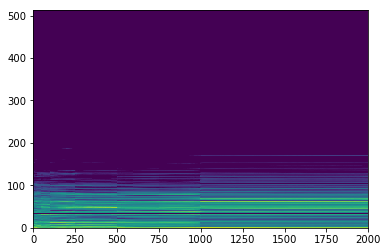

In [45]:
plt.imshow(result, origin='lower', aspect='auto',
           interpolation='nearest')

In [46]:
freq_amplitude = np.exp(result) - 1
result_complex = freq_amplitude * np.exp(1j * result_phase)
audio_dat = stft.ispectrogram(result_complex, framelength=framelength, overlap=overlap)

In [47]:
def write_stereo(a_l, a_r, s_r, name):
    a_s = np.zeros([a_l.shape[0], 2], dtype=np.int16)
    a_s[:, 0] = a_l
    a_s[:, 1] = a_r
    print(a_s.shape)
    wavfile.write(name, s_r, a_s)

In [48]:
output_filename = train_audio_name + '_'
if gen_audio_name != train_audio_name:
    output_filename += gen_audio_name + '_'
output_filename += 'nn_basic'  #classifier name, params
output_filename += '_' + str(n_samples // 1000) + 'k'

output_filename += 'prev3'  # additional info
output_filename += '.wav'
print(output_filename)

write_stereo(audio_dat, audio_dat, 44100, 'results/' + output_filename)

reich_nn_basic_1kprev3.wav
(511744, 2)
